In [13]:
# Import things
import sys
sys.path.append('..')
from cmost_exposure import Exposure, scan_headers
from cmost_hdr import create_image, magnitude_to_count_rate

import numpy as np
import astropy.units as u
import astropy.constants as cr
from astropy.table import QTable, vstack
from astropy.convolution import convolve_fft, Gaussian2DKernel
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from astropy.stats import sigma_clipped_stats
from photutils import aperture_photometry, CircularAperture, RectangularAperture, CircularAnnulus
from photutils.utils import calc_total_error

font = {'size' : 14, 'family' : 'sans-serif'}
matplotlib.rc('font', **font)

In [7]:
# Initialise some sources
mags = np.arange(6,24,0.5) * u.ABmag
src_cr_fuv = magnitude_to_count_rate(mags, band='fuv')
src_cr_nuv = magnitude_to_count_rate(mags, band='nuv')

x_pos = [0.14,0.29,0.43,0.57,0.71,0.86] * 6
y_pos = [0.14]*6 + [0.29]*6 + [0.43]*6 + [0.57]*6 + [0.71]*6 + [0.86]*6

sources_fuv = QTable([x_pos,y_pos,mags,src_cr_fuv], names=('x_pos','y_pos','mag','src_cr'))
sources_nuv = QTable([x_pos,y_pos,mags,src_cr_nuv], names=('x_pos','y_pos','mag','src_cr'))

print(sources_fuv)

x_pos y_pos   mag         src_cr      
            mag(AB)       ph / s      
----- ----- ------- ------------------
 0.14  0.14     6.0  6607983.170798067
 0.29  0.14     6.5 4169355.5138165574
 0.43  0.14     7.0  2630685.483191546
 0.57  0.14     7.5 1659850.3266371333
 0.71  0.14     8.0 1047294.7543295464
 0.86  0.14     8.5  660798.3170798067
 0.14  0.29     9.0  416935.5513816558
 0.29  0.29     9.5  263068.5483191546
 0.43  0.29    10.0  165985.0326637133
 0.57  0.29    10.5 104729.47543295466
  ...   ...     ...                ...
 0.43  0.71    19.0  41.69355513816554
 0.57  0.71    19.5  26.30685483191544
 0.71  0.71    20.0  16.59850326637133
 0.86  0.71    20.5 10.472947543295442
 0.14  0.86    21.0  6.607983170798067
 0.29  0.86    21.5  4.169355513816563
 0.43  0.86    22.0 2.6306854831915443
 0.57  0.86    22.5 1.6598503266371332
 0.71  0.86    23.0  1.047294754329544
 0.86  0.86    23.5 0.6607983170798066
Length = 36 rows


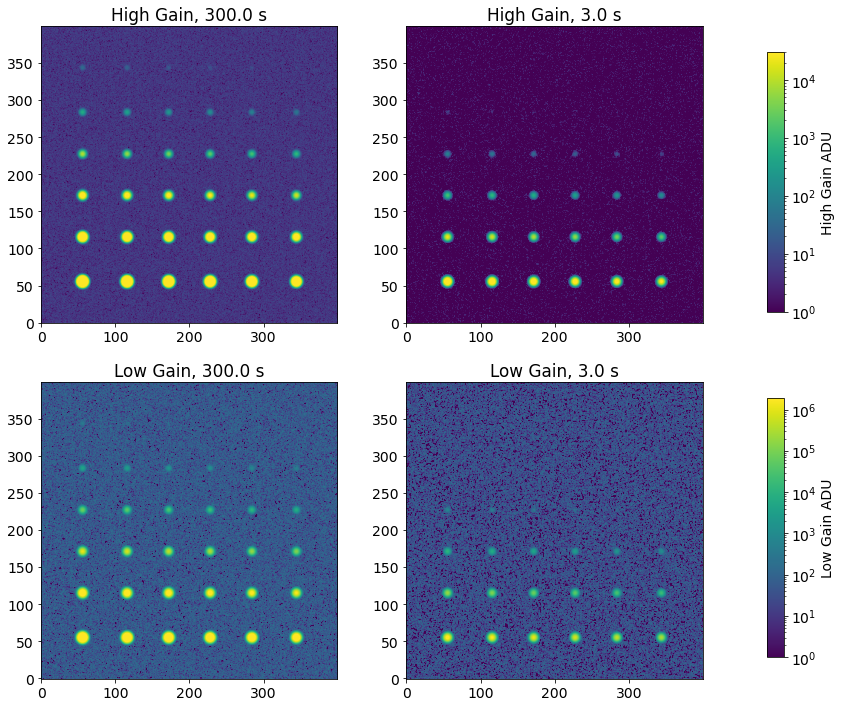

In [12]:
# Create example 2D images
b = 'fuv'
im_frame_size = 400
exp_times = [300,3] * u.s
gain_modes = ['high','low']

# 2 exposures, high/low, long/short
image1 = create_image(im_frame_size, exp_times[0], sources=sources_fuv, band=b, gain_mode=gain_modes[0])
image2 = create_image(im_frame_size, exp_times[0], sources=sources_fuv, band=b, gain_mode=gain_modes[1])
image3 = create_image(im_frame_size, exp_times[1], sources=sources_fuv, band=b, gain_mode=gain_modes[0])
image4 = create_image(im_frame_size, exp_times[1], sources=sources_fuv, band=b, gain_mode=gain_modes[1])

im1,im2,im3,im4 = image1.value, image2.value, image3.value, image4.value
im1[im1 == 0], im2[im2 == 0], im3[im3 == 0], im4[im4 == 0] = 0.1, 0.1, 0.1, 0.1

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[12,12])
highax = axes[0,0].imshow(im1, origin='lower', norm=LogNorm(vmin=1, vmax=np.max(im1)))
lowax = axes[1,0].imshow(im2, origin='lower', norm=LogNorm(vmin=1, vmax=np.max(im2)))
axes[0,1].imshow(im3, origin='lower', norm=LogNorm(vmin=1, vmax=np.max(im1)))
axes[1,1].imshow(im4, origin='lower', norm=LogNorm(vmin=1, vmax=np.max(im2)))

axes[0,0].set_title('High Gain, {}'.format(exp_times[0]))
axes[1,0].set_title('Low Gain, {}'.format(exp_times[0]))
axes[0,1].set_title('High Gain, {}'.format(exp_times[1]))
axes[1,1].set_title('Low Gain, {}'.format(exp_times[1]))

fig.subplots_adjust(right=0.9)
cbar_high = fig.add_axes([0.97, 0.55, 0.02, 0.3])
fig.colorbar(highax, cax=cbar_high, label='High Gain ADU')
cbar_low = fig.add_axes([0.97, 0.15, 0.02, 0.3])
fig.colorbar(lowax, cax=cbar_low, label='Low Gain ADU')

plt.show()

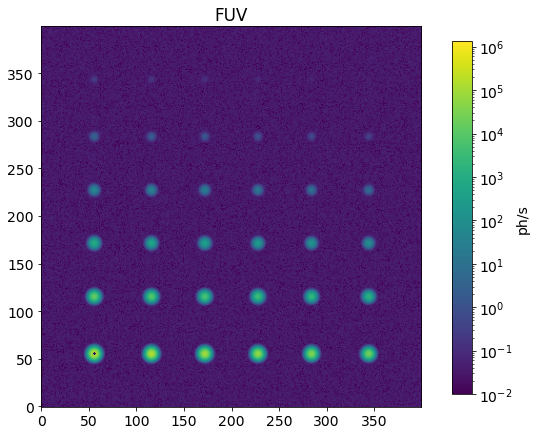

In [21]:
# Apply algorithm - FUV
gain = {'high': 1.2 * u.adu / u.electron, 'low': 10.1 * u.adu / u.electron}
read_noise = {'high': 2 * u.electron, 'low': 10 * u.electron}
well_depth = {'high': 25000 * u.electron, 'low': 190000 * u.electron}
qe = 0.4 * u.electron / u.ph

# Logic process: 
# Start with long exposure, high mode. If saturated, go to long exposure, low mode. Then short/high, short/low.
final_image_fuv = -np.ones((im_frame_size,im_frame_size)) * u.ph/u.s
fuv_ims = []
for e in exp_times:
    for g in gain_modes:
        im = create_image(im_frame_size, e, sources=sources_fuv, band='fuv', gain_mode=g)
        fuv_ims.append(im)
        
        # Define saturated as well_depth - 3*read_noise
        sat = (well_depth[g] - 3*read_noise[g]) * gain[g]
        not_sat = (final_image_fuv.value == -1) & (im < sat)
        
        # Update final_image with value selected from correct frame, converted back to ph/s
        final_image_fuv[not_sat] = im[not_sat] / gain[g] / qe / e

final_image_fuv[final_image_fuv.value <= 0] = 0.004 * final_image_fuv.unit

# Display final image (should be no saturated pixels)
fig, axes = plt.subplots(figsize=[7,7])
plt.title('FUV')
f = axes.imshow(final_image_fuv.value, origin='lower', norm=LogNorm(vmin=0.01, vmax=np.max(src_cr_fuv.value)/5))
fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.95, 0.15, 0.04, 0.7])
fig.colorbar(f, cax=cbar, label='ph/s')
plt.show()

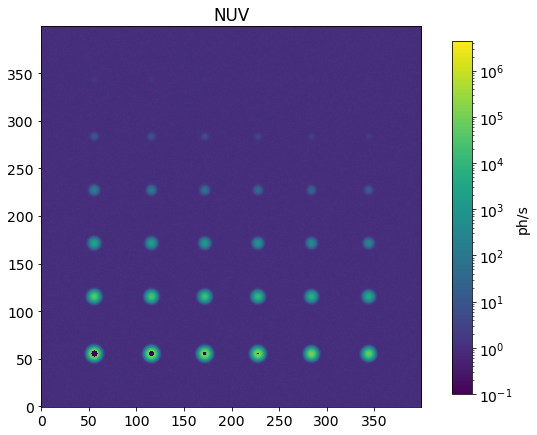

In [22]:
# Once more for NUV
final_image_nuv = -np.ones((im_frame_size,im_frame_size)) * u.ph/u.s
nuv_ims = []
for e in exp_times:
    for g in gain_modes:
        im = create_image(im_frame_size, e, sources=sources_nuv, band='nuv', gain_mode=g)
        nuv_ims.append(im)
        
        # Define saturated as well_depth - 3*read_noise
        sat = (well_depth[g] - 3*read_noise[g]) * gain[g]
        not_sat = (final_image_nuv.value == -1) & (im < sat)
        
        # Update final_image with value selected from correct frame, converted back to ph/s
        final_image_nuv[not_sat] = im[not_sat] / gain[g] / qe / e

final_image_nuv[final_image_nuv.value <= 0] = 0.004 * final_image_nuv.unit

# Display final image (should be no saturated pixels)
fig, axes = plt.subplots(figsize=[7,7])
plt.title('NUV')
f = axes.imshow(final_image_nuv.value, origin='lower', norm=LogNorm(vmin=0.1, vmax=np.max(src_cr_nuv.value)/5))
fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.95, 0.15, 0.04, 0.7])
fig.colorbar(f, cax=cbar, label='ph/s')
plt.show()

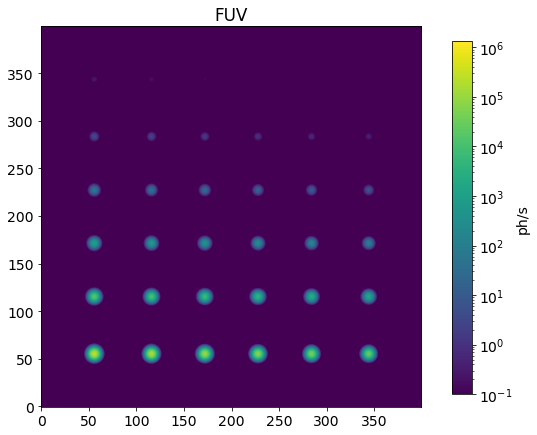

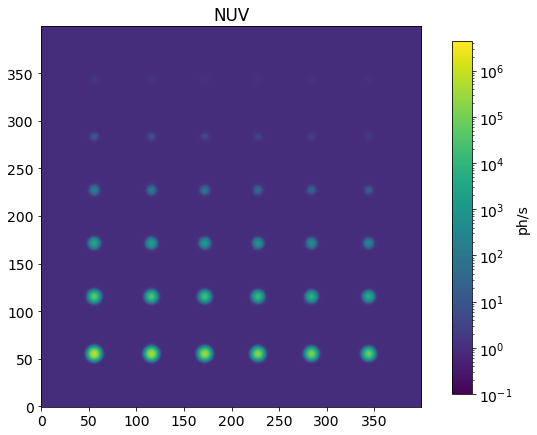

In [23]:
# Create the idealised count rate images for comparison
# Borrow code from the function for this
psf_fwhm = 2 * u.arcsec
pixel_size = 1 * u.arcsec

oversample = 6
src_frame_size = 25 # In pixels
pixel_size_init = pixel_size / oversample
src_frame_size_init = src_frame_size * oversample
im_frame_size_init = im_frame_size * oversample
shape = (im_frame_size, oversample, im_frame_size, oversample)

# Create empty oversampled image
im_array_fuv = np.zeros([im_frame_size_init,im_frame_size_init]) * u.ph / u.s
im_array_nuv = np.zeros([im_frame_size_init,im_frame_size_init]) * u.ph / u.s

# Create PSF kernel
psf_kernel = Gaussian2DKernel(psf_fwhm / pixel_size_init,
                              x_size=src_frame_size_init, y_size=src_frame_size_init)

# Add sources - FUV
source_inv_fuv = np.array([sources_fuv['y_pos'],sources_fuv['x_pos']]) # Create array of all ys and all xs
source_pix_fuv = (source_inv_fuv.transpose() * np.array(im_array_fuv.shape)).transpose().astype(int)
im_array_fuv[tuple(source_pix_fuv)] += sources_fuv['src_cr']
im_psf_fuv = convolve_fft(im_array_fuv.value, psf_kernel) * im_array_fuv.unit
im_binned_fuv = im_psf_fuv.reshape(shape).sum(-1).sum(1)

# Add sources - NUV
source_inv_nuv = np.array([sources_nuv['y_pos'],sources_nuv['x_pos']]) # Create array of all ys and all xs
source_pix_nuv = (source_inv_nuv.transpose() * np.array(im_array_nuv.shape)).transpose().astype(int)
im_array_nuv[tuple(source_pix_nuv)] += sources_nuv['src_cr']
im_psf_nuv = convolve_fft(im_array_nuv.value, psf_kernel) * im_array_nuv.unit
im_binned_nuv = im_psf_nuv.reshape(shape).sum(-1).sum(1)

# Add sky background and dark current
im_binned_fuv = im_binned_fuv + 0.015 * u.ph / u.s + 0.01 * u.electron / u.s / qe
im_binned_nuv = im_binned_nuv + 1.0 * u.ph / u.s + 0.01 * u.electron / u.s / qe

# Pure count rate images
fig, axes = plt.subplots(figsize=[7,7])
plt.title('FUV')
f = axes.imshow(im_binned_fuv.value, origin='lower', norm=LogNorm(vmin=0.1, vmax=np.max(src_cr_fuv.value)/5))
fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.95, 0.15, 0.04, 0.7])
fig.colorbar(f, cax=cbar, label='ph/s')
plt.show()

fig, axes = plt.subplots(figsize=[7,7])
plt.title('NUV')
f = axes.imshow(im_binned_nuv.value, origin='lower', norm=LogNorm(vmin=0.1, vmax=np.max(src_cr_nuv.value)/5))
fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.95, 0.15, 0.04, 0.7])
fig.colorbar(f, cax=cbar, label='ph/s')
plt.show()

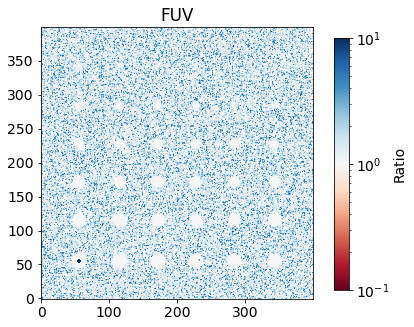

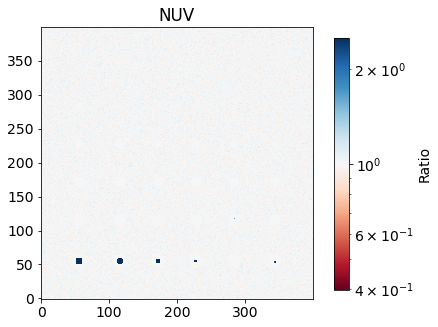

In [24]:
# Plot difference between result image and perfect input
fig, axes = plt.subplots(figsize=[5,5])
plt.title('FUV')
f = axes.imshow(im_binned_fuv.value / final_image_fuv.value, origin='lower', cmap='RdBu', norm=LogNorm(vmin=0.1, vmax=10))
fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.95, 0.15, 0.04, 0.7])
fig.colorbar(f, cax=cbar, label='Ratio')
plt.show()

a = np.abs(im_binned_fuv.value - final_image_fuv.value)
fuv_bad_index = np.unravel_index(np.argmax(a, axis=None), a.shape)
#print(fuv_bad_index)

fig, axes = plt.subplots(figsize=[5,5])
plt.title('NUV')
f = axes.imshow(im_binned_nuv.value / final_image_nuv.value, origin='lower', cmap='RdBu', norm=LogNorm(vmin=10**-0.4, vmax=10**0.4))
fig.subplots_adjust(right=0.9)
cbar = fig.add_axes([0.95, 0.15, 0.04, 0.7])
fig.colorbar(f, cax=cbar, label='Ratio')
plt.show()

a = np.abs(im_binned_nuv.value - final_image_nuv.value)
nuv_bad_index = np.unravel_index(np.argmax(a, axis=None), a.shape)
#print(nuv_bad_index)

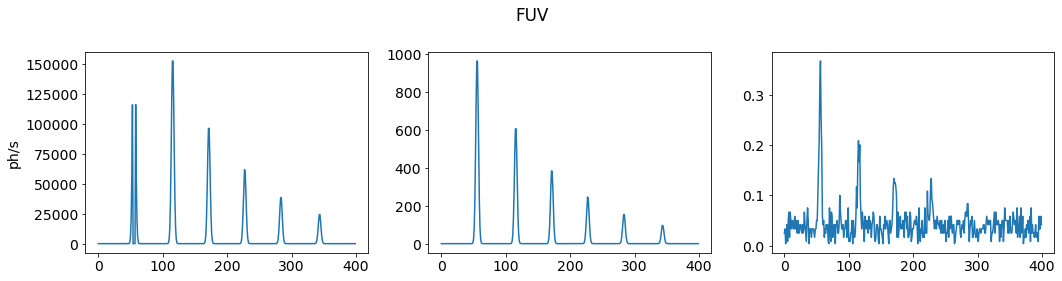

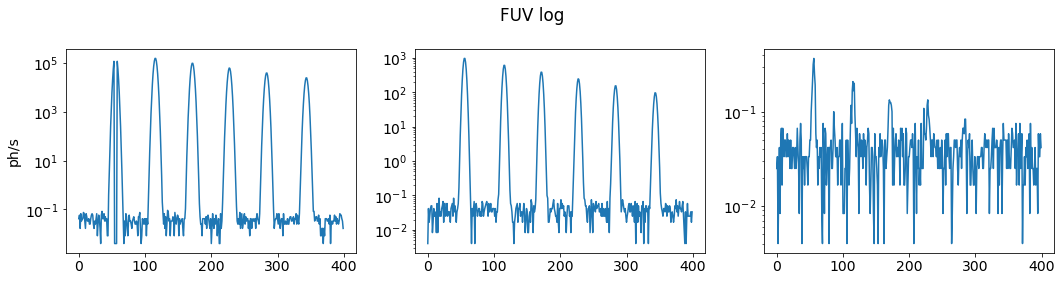

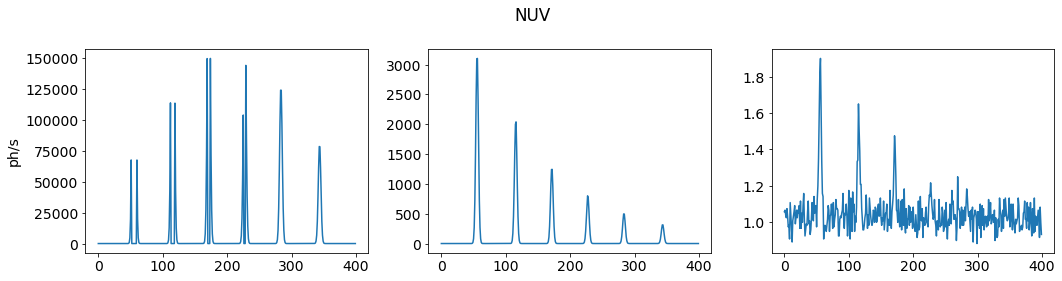

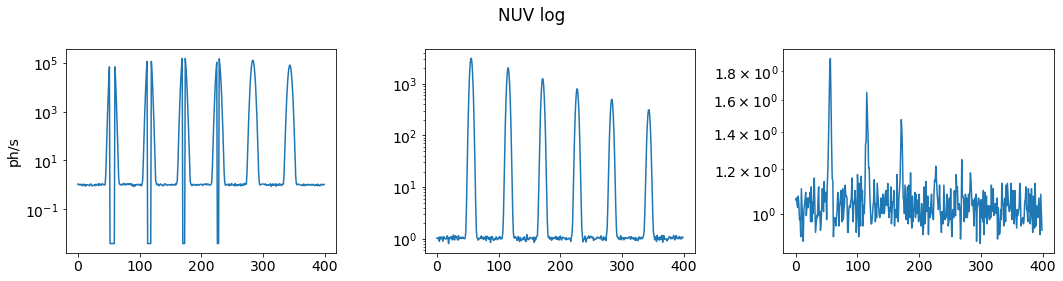

In [25]:
# Plot PSF shapes to check for discontinuity
plt.figure(figsize=[15,4])
plt.suptitle('FUV')
plt.subplot(131)
plt.plot(np.arange(len(final_image_fuv[56,:])),final_image_fuv[56,:])
plt.ylabel('ph/s')
plt.subplot(132)
plt.plot(np.arange(len(final_image_fuv[172,:])),final_image_fuv[172,:])
plt.subplot(133)
plt.plot(np.arange(len(final_image_fuv[344,:])),final_image_fuv[344,:])
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,4])
plt.suptitle('FUV log')
plt.subplot(131)
plt.semilogy()
plt.plot(np.arange(len(final_image_fuv[56,:])),final_image_fuv[56,:])
plt.ylabel('ph/s')
plt.subplot(132)
plt.semilogy()
plt.plot(np.arange(len(final_image_fuv[172,:])),final_image_fuv[172,:])
plt.subplot(133)
plt.semilogy()
plt.plot(np.arange(len(final_image_fuv[344,:])),final_image_fuv[344,:])
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,4])
plt.suptitle('NUV')
plt.subplot(131)
plt.plot(np.arange(len(final_image_nuv[56,:])),final_image_nuv[56,:])
plt.ylabel('ph/s')
plt.subplot(132)
plt.plot(np.arange(len(final_image_nuv[172,:])),final_image_nuv[172,:])
plt.subplot(133)
plt.plot(np.arange(len(final_image_nuv[344,:])),final_image_nuv[344,:])
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,4])
plt.suptitle('NUV log')
plt.subplot(131)
plt.semilogy()
plt.plot(np.arange(len(final_image_nuv[56,:])),final_image_nuv[56,:])
plt.ylabel('ph/s')
plt.subplot(132)
plt.semilogy()
plt.plot(np.arange(len(final_image_nuv[172,:])),final_image_nuv[172,:])
plt.subplot(133)
plt.semilogy()
plt.plot(np.arange(len(final_image_nuv[344,:])),final_image_nuv[344,:])
plt.tight_layout()
plt.show()

In [30]:
# Check flux using aperture photometry (and PSF-fitting photometry?)

# Generate apertures from sources
positions = np.c_[np.array(x_pos)*im_frame_size,np.array(y_pos)*im_frame_size]
apertures = CircularAperture(positions, r=12)

# Generate backgrounds from the edges
bg_apertures = CircularAnnulus(positions, 14, 20)
bg_masks = bg_apertures.to_mask(method='center')

# Get backgrounds in bg regions
bg_median_fuv = []
for mask in bg_masks:
    bg_data_fuv = mask.multiply(final_image_fuv)
    bg_data_1d_fuv = bg_data_fuv[mask.data > 0]
    _, median_sigclip_fuv, _ = sigma_clipped_stats(bg_data_1d_fuv)
    bg_median_fuv.append(median_sigclip_fuv.value)
bg_median_fuv = np.array(bg_median_fuv) * final_image_fuv.unit

error_fuv = calc_total_error(final_image_fuv.value, 2 / 300, 300) * final_image_fuv.unit

# Perform aperture photometry
result_fuv = aperture_photometry(final_image_fuv, apertures, error=error_fuv)
result_fuv['bg_median'] = bg_median_fuv
result_fuv['aper_bg'] = bg_median_fuv * apertures.area
result_fuv['aper_sum_bgsub'] = result_fuv['aperture_sum'] - result_fuv['aper_bg']

for col in result_fuv.colnames:
    result_fuv[col].info.format = '%.8g'

result_fuv.pprint_all()

 id xcenter ycenter aperture_sum aperture_sum_err  bg_median   aper_bg  aper_sum_bgsub
      pix     pix      ph / s         ph / s         ph / s     ph / s      ph / s    
--- ------- ------- ------------ ---------------- ----------- --------- --------------
  1      56      56    4120078.6        117.19051 0.041666667 18.849556      4120059.8
  2     116      56    4167821.3        117.86754 0.033333333 15.079645      4167806.2
  3     172      56    2629701.8        93.625278 0.033333333 15.079645      2629686.7
  4     228      56    1656468.9        74.307355 0.033333333 15.079645      1656453.8
  5     284      56    1047194.1        59.081868 0.033333333 15.079645        1047179
  6     344      56    660407.25        46.918841 0.033333333 15.079645      660392.17
  7      56     116    416721.83        37.270536 0.033333333 15.079645      416706.75
  8     116     116    260703.38        29.479338 0.033333333 15.079645       260688.3
  9     172     116    165790.72        23.

In [32]:
# Get backgrounds in annuli
bg_median_nuv = []
for mask in bg_masks:
    bg_data_nuv = mask.multiply(final_image_nuv)
    bg_data_1d_nuv = bg_data_nuv[mask.data > 0]
    _, median_sigclip_nuv, _ = sigma_clipped_stats(bg_data_1d_nuv)
    bg_median_nuv.append(median_sigclip_nuv.value)
bg_median_nuv = np.array(bg_median_nuv) * final_image_nuv.unit

error_nuv = calc_total_error(final_image_nuv.value, 2 / 300, 300) * final_image_nuv.unit

# Perform aperture photometry
result_nuv = aperture_photometry(final_image_nuv, apertures, error=error_nuv)
result_nuv['bg_median'] = bg_median_nuv
result_nuv['aper_bg'] = bg_median_nuv * apertures.area
result_nuv['aper_sum_bgsub'] = result_nuv['aperture_sum'] - result_nuv['aper_bg']

for col in result_nuv.colnames:
    result_nuv[col].info.format = '%.8g'

result_nuv.pprint_all()

 id xcenter ycenter aperture_sum aperture_sum_err bg_median  aper_bg  aper_sum_bgsub
      pix     pix      ph / s         ph / s        ph / s    ph / s      ph / s    
--- ------- ------- ------------ ---------------- --------- --------- --------------
  1      56      56    3884273.9        113.78752 1.0166667 459.92916        3883814
  2     116      56    3814702.1        112.76389 1.0166667 459.92916      3814242.2
  3     172      56    4540665.9        123.02672 1.0166667 459.92916        4540206
  4     228      56    4255364.3        119.09898 1.0166667 459.92916      4254904.4
  5     284      56      3385701        106.23413 1.0166667 459.92916        3385241
  6     344      56    2076406.5        83.194801 1.0166667 459.92916      2075946.5
  7      56     116    1350011.8        67.082482 1.0166667 459.92916      1349551.8
  8     116     116    851591.83        53.279072 1.0166667 459.92916       851131.9
  9     172     116    537313.68        42.320984     1.025 463.6

In [43]:
# Also get: low-gain 3s photometry for first 9, high-gain 3s for 10-12, 
# low-gain 300s for 13-18, high-gain 300s for the rest

# Get backgrounds in bg regions
bg_median_orig_fuv = []
for i, mask in enumerate(bg_masks):
    if i <= 6:
        bg_data = mask.multiply(fuv_ims[3])
        bg_data_cr = bg_data / gain['low'] / qe / exp_times[1]
    elif (i > 6) & (i <= 11):
        bg_data = mask.multiply(fuv_ims[2])
        bg_data_cr = bg_data / gain['high'] / qe / exp_times[1]
    elif (i > 11) & (i <= 17):
        bg_data = mask.multiply(fuv_ims[1])
        bg_data_cr = bg_data / gain['low'] / qe / exp_times[0]
    else:
        bg_data = mask.multiply(fuv_ims[0])
        bg_data_cr = bg_data / gain['high'] / qe / exp_times[0]
        
    bg_data_1d = bg_data_cr[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(bg_data_1d)
    bg_median_orig_fuv.append(median_sigclip.value)
bg_median_orig_fuv = np.array(bg_median_orig_fuv) * bg_data_cr.unit

# Perform aperture photometry
results_orig_fuv = []
for i in range(4):
    if i <= 1:
        exp = exp_times[0]
    else:
        exp = exp_times[1]
        
    if (i == 0) | (i == 2):
        g = 'high'
    else:
        g = 'low'
        
    # Convert to ph/s
    fuv_im_cr = fuv_ims[i] / gain[g] / qe / exp
    
    error = calc_total_error(fuv_im_cr.value, 2 / exp.value, exp.value) * fuv_im_cr.unit
    result_orig_fuv = aperture_photometry(fuv_im_cr, apertures, error=error)

    result_orig_fuv['bg_median'] = bg_median_orig_fuv
    result_orig_fuv['aper_bg'] = bg_median_orig_fuv * apertures.area
    result_orig_fuv['aper_sum_bgsub'] = result_orig_fuv['aperture_sum'] - result_orig_fuv['aper_bg']

    for col in result_orig_fuv.colnames:
        result_orig_fuv[col].info.format = '%.8g'
        
    results_orig_fuv.append(result_orig_fuv)

result_orig_fuv = vstack([results_orig_fuv[3][0:2],results_orig_fuv[2][2:3],
                          results_orig_fuv[1][3:4],results_orig_fuv[0][4:]])    
result_orig_fuv.pprint_all()

 id xcenter ycenter aperture_sum aperture_sum_err  bg_median   aper_bg  aper_sum_bgsub
      pix     pix      ph / s         ph / s         ph / s     ph / s      ph / s    
--- ------- ------- ------------ ---------------- ----------- --------- --------------
  1      56      56    6020824.2        1416.7366           0         0      6020824.2
  2     116      56    4168599.4        1178.8699           0         0      4168599.4
  3     172      56    1395204.7        682.10651           0         0      1395204.7
  4     228      56    191656.15        25.275956           0         0      191656.15
  5     284      56    33791.718        10.614102           0         0      33791.718
  6     344      56    30899.857        10.149859           0         0      30899.857
  7      56     116    28548.816        9.7561687           0         0      28548.816
  8     116     116    26360.731        9.3749244           0         0      26360.731
  9     172     116    23580.962        8.8

In [42]:
# Once more for the NUV

# Get backgrounds in bg regions
bg_median_orig_nuv = []
for i, mask in enumerate(bg_masks):
    if i <= 6:
        bg_data = mask.multiply(nuv_ims[3])
        bg_data_cr = bg_data / gain['low'] / qe / exp_times[1]
    elif (i > 6) & (i <= 11):
        bg_data = mask.multiply(nuv_ims[2])
        bg_data_cr = bg_data / gain['high'] / qe / exp_times[1]
    elif (i > 11) & (i <= 17):
        bg_data = mask.multiply(nuv_ims[1])
        bg_data_cr = bg_data / gain['low'] / qe / exp_times[0]
    else:
        bg_data = mask.multiply(nuv_ims[0])
        bg_data_cr = bg_data / gain['high'] / qe / exp_times[0]
        
    bg_data_1d = bg_data_cr[mask.data > 0]
    _, median_sigclip, _ = sigma_clipped_stats(bg_data_1d)
    bg_median_orig_nuv.append(median_sigclip.value)
bg_median_orig_nuv = np.array(bg_median_orig_nuv) * bg_data_cr.unit

# Perform aperture photometry
results_orig_nuv = []
for i in range(4):
    if i <= 1:
        exp = exp_times[0]
    else:
        exp = exp_times[1]
        
    if (i == 0) | (i == 2):
        g = 'high'
    else:
        g = 'low'
        
    # Convert to ph/s
    nuv_im_cr = nuv_ims[i] / gain[g] / qe / exp
    
    error = calc_total_error(nuv_im_cr.value, 2 / exp.value, exp.value) * nuv_im_cr.unit
    result_orig_nuv = aperture_photometry(nuv_im_cr, apertures, error=error)

    result_orig_nuv['bg_median'] = bg_median_orig_nuv
    result_orig_nuv['aper_bg'] = bg_median_orig_nuv * apertures.area
    result_orig_nuv['aper_sum_bgsub'] = result_orig_nuv['aperture_sum'] - result_orig_nuv['aper_bg']

    for col in result_orig_nuv.colnames:
        result_orig_nuv[col].info.format = '%.8g'
        
    results_orig_nuv.append(result_orig_nuv)

result_orig_nuv = vstack([results_orig_nuv[3][0:2],results_orig_nuv[2][2:3],results_orig_nuv[1][3:4],results_orig_nuv[0][4:]])    
result_orig_nuv.pprint_all()

 id xcenter ycenter aperture_sum aperture_sum_err bg_median   aper_bg  aper_sum_bgsub
      pix     pix      ph / s         ph / s        ph / s     ph / s      ph / s    
--- ------- ------- ------------ ---------------- ---------- --------- --------------
  1      56      56     10852015         1901.983          0         0       10852015
  2     116      56    8881001.2        1720.6205          0         0      8881001.2
  3     172      56    2021123.8         820.9196          0         0      2021123.8
  4     228      56    238607.08         28.20243          0         0      238607.08
  5     284      56    39912.039        11.535174          0         0      39912.039
  6     344      56    37617.256        11.198704          0         0      37617.256
  7      56     116    35273.882         10.84434          0         0      35273.882
  8     116     116      32811.5        10.459052 0.83333333 376.99112      32434.509
  9     172     116    30124.862        10.021792 0.83

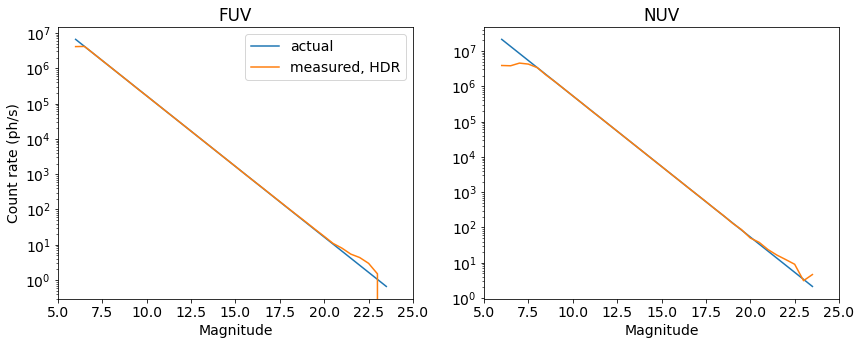

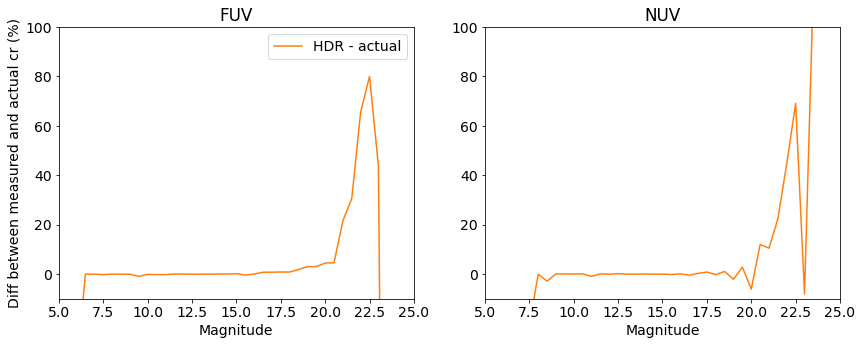

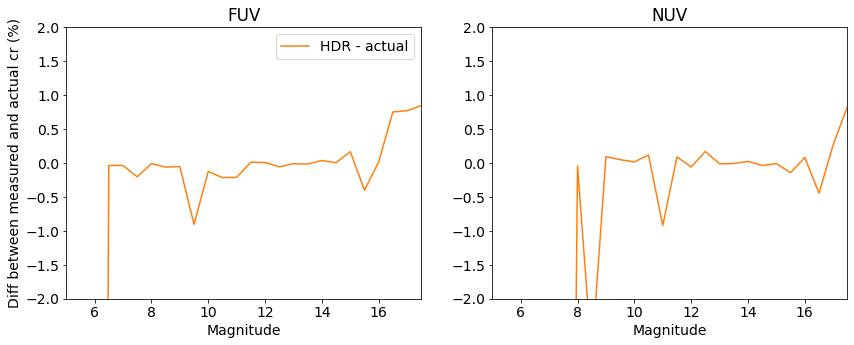

In [47]:
# Plot ideal and measured count rates against each other
plt.figure(figsize=[14,5])
plt.subplot(121)
plt.title('FUV')
plt.semilogy()
plt.plot(mags,src_cr_fuv,label='actual')
plt.plot(mags,result_fuv['aper_sum_bgsub'],label='measured, HDR')
plt.xlabel('Magnitude')
plt.ylabel('Count rate (ph/s)')
plt.xlim([5,25])
plt.legend()
plt.subplot(122)
plt.title('NUV')
plt.semilogy()
plt.plot(mags,src_cr_nuv)
plt.plot(mags,result_nuv['aper_sum_bgsub'])
plt.xlabel('Magnitude')
plt.xlim([5,25])
plt.show()

plt.figure(figsize=[14,5])
plt.subplot(121)
plt.title('FUV')
plt.plot([0,0],[0,0])
plt.plot(mags,(result_fuv['aper_sum_bgsub'] - src_cr_fuv) / src_cr_fuv * 100,label='HDR - actual')
plt.xlabel('Magnitude')
plt.ylabel('Diff between measured and actual cr (%)')
plt.xlim([5,25])
plt.ylim([-10,100])
plt.legend()
plt.subplot(122)
plt.title('NUV')
plt.plot([0,0],[0,0])
plt.plot(mags,(result_nuv['aper_sum_bgsub'] - src_cr_nuv) / src_cr_nuv * 100)
plt.xlabel('Magnitude')
plt.xlim([5,25])
plt.ylim([-10,100])
plt.show()

plt.figure(figsize=[14,5])
plt.subplot(121)
plt.title('FUV')
plt.plot([0,0],[0,0])
plt.plot(mags,(result_fuv['aper_sum_bgsub'] - src_cr_fuv) / src_cr_fuv * 100,label='HDR - actual')
plt.xlabel('Magnitude')
plt.ylabel('Diff between measured and actual cr (%)')
plt.xlim([5,17.5])
plt.ylim([-2,2])
plt.legend()
plt.subplot(122)
plt.title('NUV')
plt.plot([0,0],[0,0])
plt.plot(mags,(result_nuv['aper_sum_bgsub'] - src_cr_nuv) / src_cr_nuv * 100)
plt.xlabel('Magnitude')
plt.xlim([5,17.5])
plt.ylim([-2,2])
plt.show()

In [161]:
# Find ideal saturation definition by looking at saturated image from test detector
saturated_low_file = ''
saturated_high_file = '../data/012121/cmostjpl003_20210121234130.fits'

all_files = scan_headers('../data/020321')
all_files.sort('DATE')
all_files.pprint_all()

                   FILEPATH                    READOUTM            DATE            EXPTIME LED   TEMP  CAMERAID      DETID      GAIN
---------------------------------------------- -------- -------------------------- ------- --- ------- -------- --------------- ----
../data/020321/cmostjpl001_20210203182644.fits  DEFAULT 2021-02-03 18:26:49.293675  1000.0 1.6   140.0 cmostjpl EuropaBSI-1-7-3 high
../data/020321/cmostjpl001_20210203182705.fits  DEFAULT 2021-02-03 18:27:12.254249  1975.0 1.6   140.0 cmostjpl EuropaBSI-1-7-3 high
../data/020321/cmostjpl001_20210203185558.fits  DEFAULT 2021-02-03 18:56:09.799281  3902.0 1.6   140.0 cmostjpl EuropaBSI-1-7-3 high
../data/020321/cmostjpl001_20210203185638.fits  DEFAULT 2021-02-03 18:56:56.544894  6501.0 1.6 140.001 cmostjpl EuropaBSI-1-7-3 high
../data/020321/cmostjpl001_20210203192604.fits  DEFAULT 2021-02-03 19:26:33.605327 10833.0 1.6   140.0 cmostjpl EuropaBSI-1-7-3 high
../data/020321/cmostjpl001_20210203193334.fits  DEFAULT 2021-02-03 19